In [1]:
import os
import glob
import numpy as np
import scipy as sp
import pandas as pd

import cv2
from skimage.io import imshow, imread, imsave

# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
# Albumentations
import albumentations as A

# Keras
# from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 

#visualisation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from IPython.display import HTML, Image

#warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:

#source: https://www.kaggle.com/jpmiller/nfl-punt-analytics/edit
# set additional display options for report
pd.set_option("display.max_columns", 100)
th_props = [('font-size', '13px'), ('background-color', 'white'), 
            ('color', '#666666')]
td_props = [('font-size', '15px'), ('background-color', 'white')]
styles = [dict(selector="td", props=td_props), dict(selector="th", 
            props=th_props)]



In [3]:
#Helper function to display the images in a grid
# Source: https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy which was pointed by
# this excellent article: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9
def gallery(array, ncols=3):
    '''
    Function to arange images into a grid.
    INPUT:
        array - numpy array containing images
        ncols - number of columns in resulting imahe grid
    OUTPUT:
        result - reshaped array into a grid with given number of columns
    '''
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


# helper function for loading some images into memory
def load_image(image_id):
    file_path = image_id 
    image = imread(Image_Data_Path + file_path)
    return image


In [4]:
data_dir = '../input/cassava-leaf-disease-classification/'
Image_Data_Path = data_dir + '/train_images/'
train_data = pd.read_csv(data_dir + '/train.csv')

# we load and store the first 10 images in memory for faster access
train_images = train_data["image_id"][:10].apply(load_image)

# albumentations

(-0.5, 799.5, 599.5, -0.5)

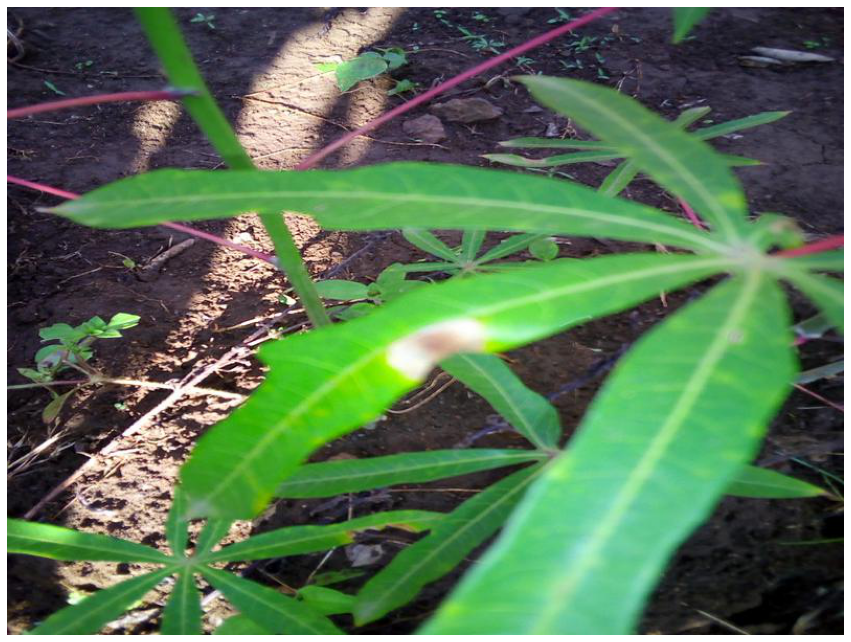

In [5]:
curr_img = train_images[7]
plt.figure(figsize = (15,15))
plt.imshow(curr_img)
plt.axis('off')

Text(0.5, 1.0, 'Augmentation examples')

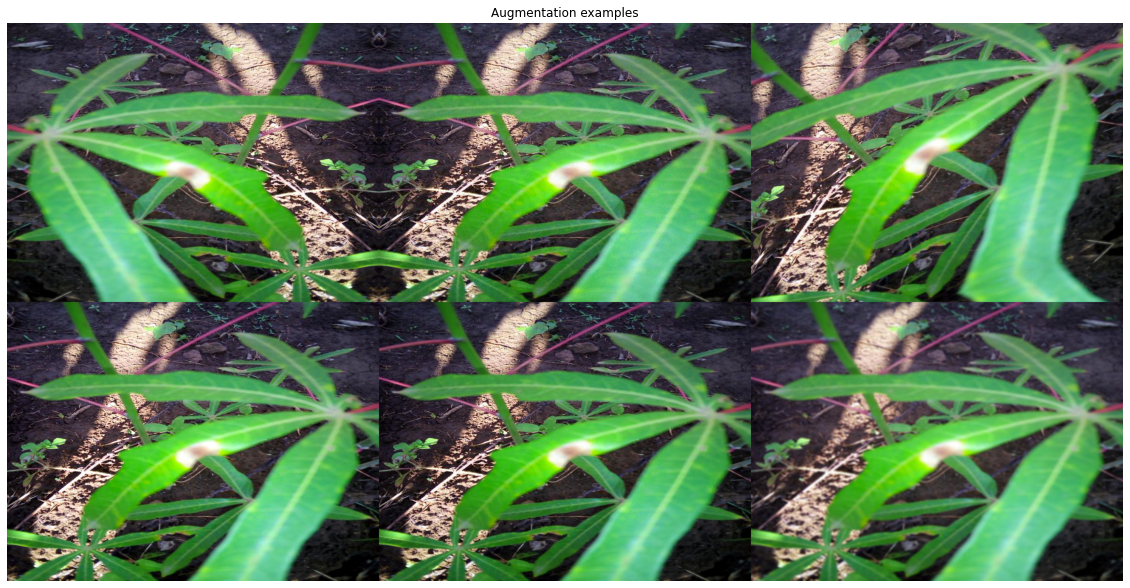

In [6]:
# initialize augmentations
horizontal_flip = A.HorizontalFlip(p=1)
rotate = A.ShiftScaleRotate(p=1)
gaus_noise = A.GaussNoise() 
bright_contrast = A.RandomBrightnessContrast(p=1) 
gamma = A.RandomGamma(p=1) 
blur = A.Blur()

# apply augmentations to images
img_flip = horizontal_flip(image = curr_img)
img_gaus = gaus_noise(image = curr_img)
img_rotate = rotate(image = curr_img)
img_bc = bright_contrast(image = curr_img)
img_gamma = gamma(image = curr_img)
img_blur = blur(image = curr_img)

# access the augmented image by 'image' key
img_list = [img_flip['image'],img_gaus['image'], img_rotate['image'], img_bc['image'], img_gamma['image'], img_blur['image']]

# visualize the augmented images
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(gallery(np.array(img_list), ncols = 3))
plt.title('Augmentation examples')

# keras built-in

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 


2021-12-20 22:30:57.937857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [8]:
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)) 

curr_img_array = img_to_array(curr_img)
curr_img_array = curr_img_array.reshape((1,) + curr_img_array.shape)

i = 0
for batch in datagen.flow(
    curr_img_array,
    batch_size=1,
    save_to_dir='.',
    save_prefix='Augmented_image',
    save_format='jpeg'):
    i += 1
    # hard-coded stop - without it, the generator enters an infinite loop
    if i > 9: 
        break  

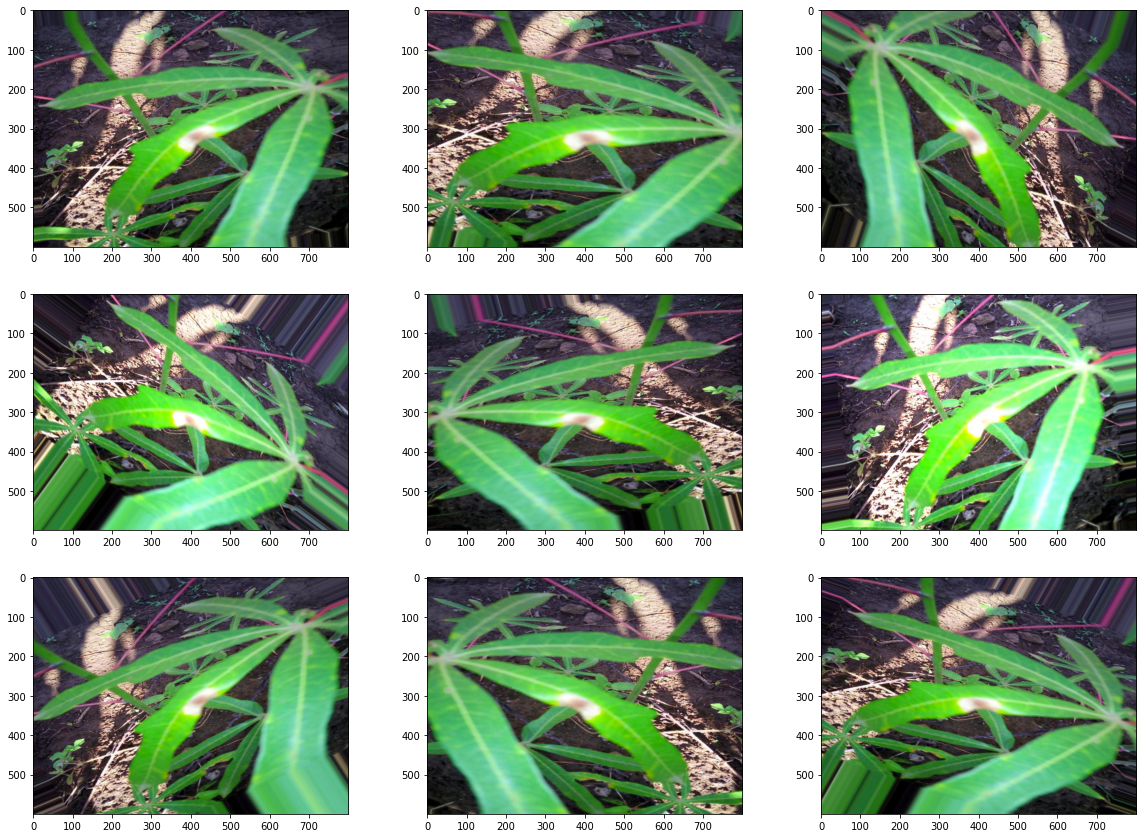

In [9]:
# Let's look at the augmented images
aug_images = []
for img_path in glob.glob("*.jpeg"):
    aug_images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
columns = 3
for i, image in enumerate(aug_images[0:9]):
    plt.subplot(len(aug_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

Text(0.5, 1.0, 'Augmentation examples')

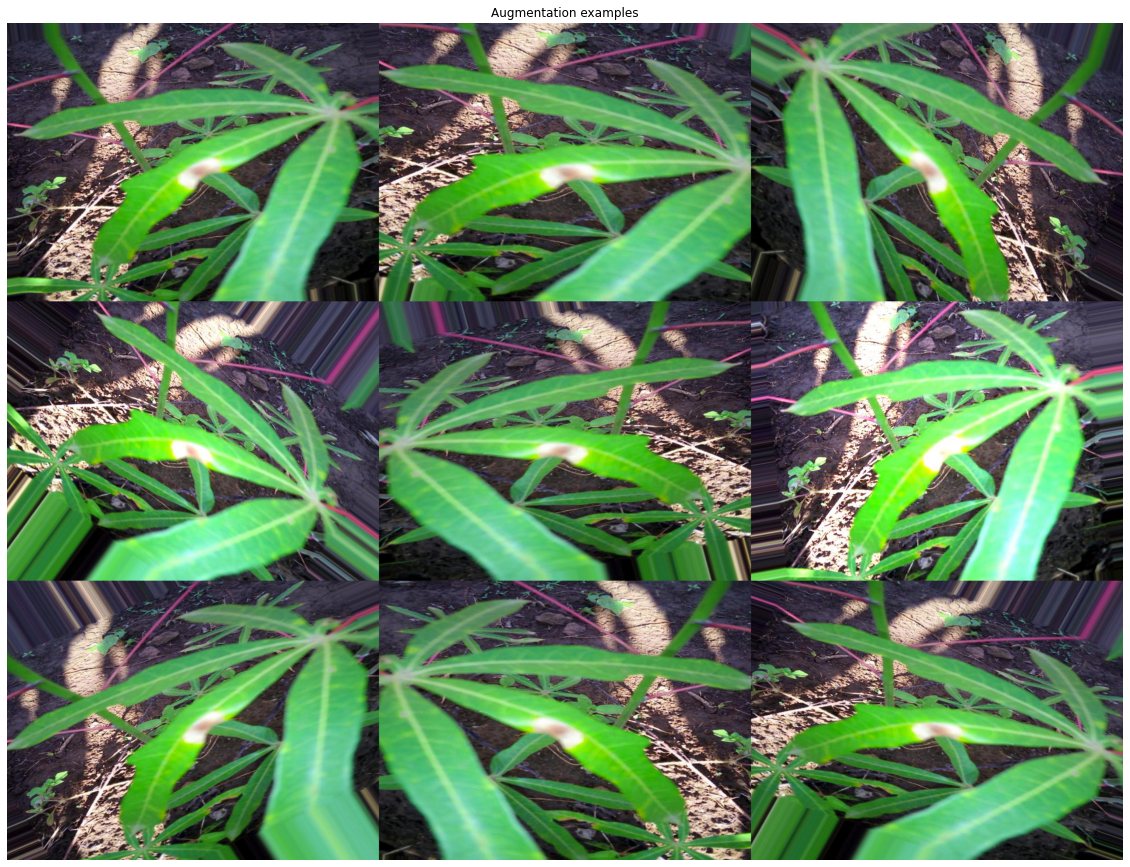

In [10]:
# visualize the augmented images
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(gallery(np.array(aug_images[0:9]), ncols = 3))
plt.title('Augmentation examples')

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = tf.keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%

    
    # Base
    pretrained_base,
    # model head definition 
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

2021-12-20 22:31:07.463992: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 22:31:07.467317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-20 22:31:07.510844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 22:31:07.511461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-12-20 22:31:07.511534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-20 22:31:07.557863: I tensorflow/stream_executor/platform/def